# 2º Trabalho Prático: Planejamento de Caminhos

##### Importação de Bibliotecas

In [17]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

##### Funções que executam operações com matrizes de rotação e transformação de coordenadas em relação a um referencial:

In [18]:
def rotation_z (theta):
    return np.array ([[ np.cos(theta) , -np.sin(theta) , 0 ],
                      [ np.sin(theta) ,  np.cos(theta) , 0 ],
                      [ 0             ,  0             , 1 ]])
  
def rotation_y (theta):
    return np.array ([[  np.cos(theta) , 0 , np.sin(theta) ],
                      [  0             , 1 , 0             ],
                      [ -np.sin(theta) , 0 , np.cos(theta) ]])

def rotation_x (theta):
    return np.array ([[ 1 , 0             ,  0             ],
                      [ 0 , np.cos(theta) , -np.sin(theta) ],
                      [ 0 , np.sin(theta) ,  np.cos(theta) ]])

def rotation_matrix (alpha, beta, gamma):
    
    return rotation_z (alpha) @ rotation_y (beta) @ rotation_x (gamma)

def homogeneous_transformation_matrix (rotation_matrix, translation_vector):
    
    matrix = np.column_stack ((rotation_matrix, translation_vector[:3]))
    matrix = np.row_stack ((matrix, [0, 0, 0, 1]))
    return matrix

def reverse_transformation (a_to_b_orientation, a_to_b_position):
    
    b_to_a_rotation = np.transpose (rotation_matrix (*np.flip (a_to_b_orientation)))
    b_to_a_position = -1 * b_to_a_rotation @ a_to_b_position[:3]
    return homogeneous_transformation_matrix (b_to_a_rotation, b_to_a_position)

def composite_transformation (a_to_b_rotation, a_to_b_position, b_to_c_rotation, b_to_c_position):
    
    a_to_c_rotation = b_to_c_rotation @ a_to_b_rotation
    a_to_c_position = homogeneous_transformation_matrix (b_to_c_rotation, b_to_c_position) @ a_to_b_position
    return homogeneous_transformation_matrix (a_to_c_rotation, a_to_c_position)

def to_world_transformation_matrix (c_object):
    
    object_to_world_rotation = rotation_matrix (*np.flip (c_object.global_orientation))
    return homogeneous_transformation_matrix (object_to_world_rotation, c_object.global_position)

def to_robot_transformation_matrix (c_object, robot):
    
    world_to_robot_rotation = np.transpose (rotation_matrix (*np.flip (robot.global_orientation)))
    world_to_robot_position = -1 * world_to_robot_rotation @ robot.global_position[:3]

    object_to_world_rotation =  rotation_matrix (*np.flip (c_object.global_orientation))
    return composite_transformation (object_to_world_rotation, c_object.global_position, world_to_robot_rotation, world_to_robot_position)

##### Funções de ...

In [19]:
# Normalize angle to the range [-pi,pi)
def normalize_angle (angle):
    return np.mod (angle + np.pi, 2 * np.pi) - np.pi

In [20]:
# Usar nomes de funções e atributos mais descritivos
def att_force (q, goal, katt = 0.1):
    return katt * (goal - q)

def rep_force(q, obs, R=4, krep=.1):
    
    # Obstáculo: (x, y, r)
    v = q[0:2] - obs[0:2]
    d1 = np.linalg.norm(v)  
    d = np.linalg.norm(v) - d1  
        
    rep = (1/d**2) * ((1/d) - (1/R)) * (v/d)    
    
    if d1 > R:
        rep = np.zeros_like(rep)
    
    return krep * rep

In [106]:
def read_binary_image (image_address):
    image = mpimg.imread (image_address)
    for row in range(len(image)):
        for col in range(len(image[row])):
            image[row][col] = 1 if image[row][col] < 0.5 else 0
    print (image)
    return image

In [104]:
class World:
    
    def __init__ (self, image_address, real_dimensions):
        self.image_address = image_address
        self.world_matrix = read_binary_image (self.image_address)
        self.real_dimensions = real_dimensions
        self.scale = self.world_matrix.shape[:2] / self.real_dimensions
        
    def is_cell_area_free (self, row, col, cell_size, buffer):
        area_size = cell_size * self.scale
        buffer = buffer * self.scale[0] / 2
        left = int (max (0, col * area_size[0] - buffer))
        right = int (min ((col + 1) * area_size[0] + buffer, self.world_matrix.shape[0]))
        top = int (max (0, row * area_size[1] - buffer))
        bottom = int (min ((row + 1) * area_size[1] + buffer, self.world_matrix.shape[1]))
        return 1 if np.sum (self.world_matrix[top:bottom, left:right]) == 0 else 0
        
    def discretize_world (self, cell_size = 1, buffer = 1):
        num_rows, num_cols = (self.real_dimensions / cell_size).astype(int)
        grid = np.zeros ((num_rows, num_cols))
        for row in range (num_rows):
            for col in range (num_cols):
                grid[row][col] = self.is_cell_area_free (row, col, cell_size, buffer)

        fig = plt.figure (figsize = (8,8), dpi = 100)
        ax = fig.add_subplot (111, aspect = 'equal')

        ax.grid (which = 'major', axis = 'both', linestyle = '-', color = 'r', linewidth = 1)
        ax.set_xticks (np.arange (0, self.real_dimensions[1], cell_size))
        ax.set_yticks (np.arange (0, self.real_dimensions[0], cell_size))
        ax.imshow (1 - grid, cmap = 'Greys', extent = (0, self.real_dimensions[1], 0, self.real_dimensions[0]), alpha = 0.6)
        return grid

In [23]:
client = RemoteAPIClient()
sim = client.require('sim')

class CoppeliaObject:
    
    def __init__ (self, name):
        self.name = name
        self.handle = sim.getObject (name)
        self.update_location ()
        
    def new_location (self, position, orientation):
        sim.setObjectPosition (self.handle, position)
        sim.setObjectOrientation (self.handle, orientation)
        self.update_location ()
        
    def update_location (self):
        self.global_position = sim.getObjectPosition (self.handle) + [1]
        self.global_orientation = sim.getObjectOrientation (self.handle)

class CoppeliaRobot (CoppeliaObject):
    
    def __init__ (self, name, length, width, wheels, laser):
        # wheel_joints recebe um vetor de objetos do tipo Coppelia_Wheel
        self.length = length
        self.width = width
        self.wheels = wheels
        self.laser = laser
        CoppeliaObject.__init__ (self, name)

class CoppeliaWheel (CoppeliaObject):
    
    def __init__ (self, name, radius):
        self.radius = radius
        CoppeliaObject.__init__ (self, name)

class CoppeliaLaser (CoppeliaObject):
    
    def __init__ (self, name, laser_range_data, laser_angle_data):
        self.laser_range_data = laser_range_data
        self.laser_angle_data = laser_angle_data

In [24]:
def read_sensor_data (range_data_signal_id="hokuyo_range_data", angle_data_signal_id="hokuyo_angle_data"):
    
    while sim.getStringSignal (range_data_signal_id) == None:
        continue
        
    string_range_data = sim.getStringSignal (range_data_signal_id)
    string_angle_data = sim.getStringSignal (angle_data_signal_id)

    raw_range_data = sim.unpackFloatTable (string_range_data)
    raw_angle_data = sim.unpackFloatTable (string_angle_data)

    return np.array ([raw_angle_data, raw_range_data]).T

In [25]:
def A_star (start, end, binary_world):
    pass

#moves the referential from the center of the world to the top left corner of the grid and finds the correspondent cell
def find_grid_position (global_pos, cell_size, grid_size):
    x_pos = np.floor (global_pos[0] / cell_size + grid_size[1] / 2)
    y_pos = np.floor (global_pos[1] / cell_size + grid_size[0] / 2)
    return np.array ((x_pos, y_pos))

def find_goal (robot, goal, world_map, cell_size):
    robot_cell = find_grid_position (robot.global_position, cell_size, [len (world_map), len (world_map[0])])
    goal_cell = find_grid_position (goal.global_position, cell_size, [len (world_map), len (world_map[0])])
    path = A_star (robot_cell, goal_cell, world_map)

In [60]:
x = range (0, 3)
y = range (0, 3)
matrix = np.array([[0,1,1,1,0],
          [0,0,0,1,0],
          [0,0,0,1,0],
          [0,0,0,0,0]])
print (matrix[y, x])

[0 0 0]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


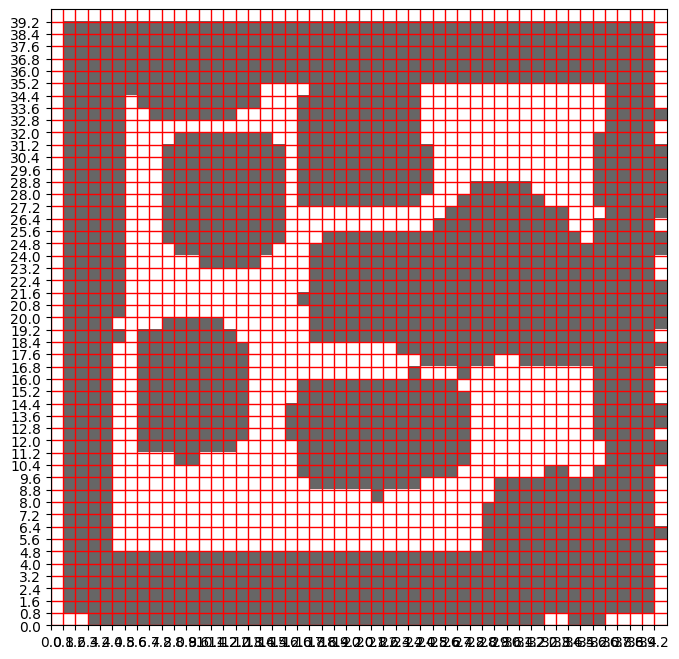

In [108]:
sim.setStepping (True)
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/cave.ttt")
sim.startSimulation ()

rear_right_wheel = CoppeliaWheel ("/rollingJoint_rr", 0.0475)
rear_left_wheel = CoppeliaWheel ("/rollingJoint_rl", 0.0475)
front_right_wheel = CoppeliaWheel ("/rollingJoint_fr", 0.0475)
front_left_wheel = CoppeliaWheel ("/rollingJoint_fl", 0.0475)
wheels = [rear_right_wheel, rear_left_wheel, front_right_wheel, front_left_wheel]
hokuyo = CoppeliaLaser ("/youBot/fastHokuyo", "hokuyo_range_data", "hokuyo_angle_data")
KUKA_youbot = CoppeliaRobot ("/youBot", 0.58, 0.38, wheels, hokuyo)
goal = CoppeliaObject ("/Goal")

world = World ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/imagens/cave.png", np.array([40,40]))
world_map = world.discretize_world (0.8, 0) # Cell size must be the division of real_dimension by a full number
find_goal (KUKA_youbot, goal, world_map, 0.8)

sim.stopSimulation ()
time.sleep (5)

In [ ]:
# Iniciar simulação carregando a cena desejada, para facilitar a correção o teste em cenas diferentes
sim.startSimulation() 

# Observações gerais:
## Utilizar as funções e classes acima
## Diminuir o código livre transformando o maximo possivel em funções reutilizaveis
## Usar nomes de funções e atributos mais descritivos
## Utilizar sempre snake_case (é uma boa prática não variar o formato da declaração de funçoes e variaveis)
## Na hora de dividir o código em celulas, agrupe funções que tem objetivos ou métodos comuns e possam ser explicadas juntas na documentação

# Handle para os dados do LASER e do Robô
robotname = './Pioneer_p3dx'
robotname_R_Motor = './Pioneer_p3dx/Pioneer_p3dx_rightMotor'
robotname_L_Motor = './Pioneer_p3dx/Pioneer_p3dx_leftMotor'
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

robotHandle = sim.getObjectHandle(robotname)    

robotLeftMotorHandle  = sim.getObjectHandle(robotname_L_Motor)
robotRightMotorHandle = sim.getObjectHandle(robotname_R_Motor)

robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)

goalFrame = sim.getObjectHandle('./ReferenceFrame')

position_goal = sim.getObjectPosition(goalFrame, sim.handle_world)
orientation_goal = sim.getObjectOrientation(goalFrame, sim.handle_world) 

sim.setObjectPosition(goalFrame, [position_goal[0], position_goal[1], 0], sim.handle_world)
sim.setObjectOrientation(goalFrame, [orientation_goal[0], orientation_goal[1], orientation_goal[2]], sim.handle_world) 

L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

rho = np.inf

while True :
        
    while rho > .05:

        robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
        robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)        
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])        


        laser_data = read_sensor_data(laser_range_data, laser_angle_data)
        distLaser = []
        força_AtracTot = 0.0
        força_RepulsTot = 0.0

        for i in laser_data:
            f1 = 0
            f2 = 0
            d1 = i[0]  # Correção aqui
            ang1 = i[1]  # Correção aqui

            x = d1 * np.cos(ang1)
            y = d1 * np.sin(ang1)
            distLaser = np.array([x ,y, 0])
            f1 = att_force(distLaser, position_goal,0.0001)
            f2 = rep_force(position_goal, distLaser, 5, 1)
            força_AtracTot += f1
            força_RepulsTot += f2

        dx, dy = força_AtracTot[0:2] + força_RepulsTot

        dx1, dy1 = position_goal[:2] - robotConfig[:2]
        rho = np.sqrt(dx1**2 + dy1**2)


        alpha = normalize_angle(-robotOri[2] + np.arctan2(dy,dx))
        beta = normalize_angle(orientation_goal[2] - np.arctan2(dy,dx))
        
        kr = 1
        kt = 2

        print("Força de atração ", dx, " Força de repulsão ", dy)
        
        v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(dy,dx) - robotConfig[2])
                
        # Limit v,w to +/- max
        print("Velocidade do robô ",v," velocidade angular do robot ", w)
        # v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        print("Velocidade do robô 2: ",v," velocidade angular do robot 2: ", w)

        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)
        
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)

    break

sim.setJointTargetVelocity(robotRightMotorHandle, 0)
sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

sim.stopSimulation ()
time.sleep (5)